In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
df1 = pd.read_csv('/content/drive/MyDrive/G2M/data/Cab_Data.csv')
df2= pd.read_csv('/content/drive/MyDrive/G2M/data/City.csv')
df3= pd.read_csv('/content/drive/MyDrive/G2M/data/Customer_ID.csv')
df4= pd.read_csv('/content/drive/MyDrive/G2M/data/Transaction_ID.csv')

In [3]:
# For df1
print(df1.dtypes)

# For df2
print(df2.dtypes)

# For df3
print(df3.dtypes)

# For df4
print(df4.dtypes)

Transaction ID      int64
Date of Travel      int64
Company            object
City               object
KM Travelled      float64
Price Charged     float64
Cost of Trip      float64
dtype: object
City          object
Population    object
Users         object
dtype: object
Customer ID            int64
Gender                object
Age                    int64
Income (USD/Month)     int64
dtype: object
Transaction ID     int64
Customer ID        int64
Payment_Mode      object
dtype: object


In [4]:
# Find common columns between df1 and df2
common_cols_1_2 = set(df1.columns) & set(df2.columns)
print(common_cols_1_2, "df1 and df2")

# Find common columns between df1 and df3
common_cols_1_3 = set(df4.columns) & set(df3.columns)
print(common_cols_1_3, "df4 and df3")

# Find common columns between df1 and df4
common_cols_1_4 = set(df1.columns) & set(df4.columns)
print(common_cols_1_4, "df1,df4")


{'City'} df1 and df2
{'Customer ID'} df4 and df3
{'Transaction ID'} df1,df4


In [5]:
merged_df = pd.merge(df1, df4, on='Transaction ID', how='inner')

In [6]:
merged_df = pd.merge(merged_df, df3, on='Customer ID', how='left')

In [7]:
merged_df = pd.merge(merged_df, df2, on='City', how='left')

In [8]:
merged_df.columns

Index(['Transaction ID', 'Date of Travel', 'Company', 'City', 'KM Travelled',
       'Price Charged', 'Cost of Trip', 'Customer ID', 'Payment_Mode',
       'Gender', 'Age', 'Income (USD/Month)', 'Population', 'Users'],
      dtype='object')

In [9]:
merged_df['Travel_Day'] = pd.to_datetime(merged_df['Date of Travel']).dt.day

In [10]:
merged_df['Population'] = pd.to_numeric(merged_df['Population'].str.replace(',', ''), errors='coerce')
merged_df['Users'] = pd.to_numeric(merged_df['Users'].str.replace(',', ''), errors='coerce')


In [11]:
from sklearn.preprocessing import StandardScaler

# Select numerical columns to scale
num_cols = ['KM Travelled', 'Price Charged', 'Cost of Trip', 'Age', 'Income (USD/Month)', 'Population', 'Users']

# Initialize scaler
scaler = StandardScaler()

# Fit and transform the selected columns
merged_df[num_cols] = scaler.fit_transform(merged_df[num_cols])

In [12]:
# Calculate Profit
merged_df['Profit'] = merged_df['Price Charged'] - merged_df['Cost of Trip']

# Calculate Price per KM
merged_df['Price per KM'] = merged_df['Price Charged'] / merged_df['KM Travelled']

In [13]:
merged_df.columns

Index(['Transaction ID', 'Date of Travel', 'Company', 'City', 'KM Travelled',
       'Price Charged', 'Cost of Trip', 'Customer ID', 'Payment_Mode',
       'Gender', 'Age', 'Income (USD/Month)', 'Population', 'Users',
       'Travel_Day', 'Profit', 'Price per KM'],
      dtype='object')

In [26]:
len(merged_df)

359392

<Axes: xlabel='Price Charged'>

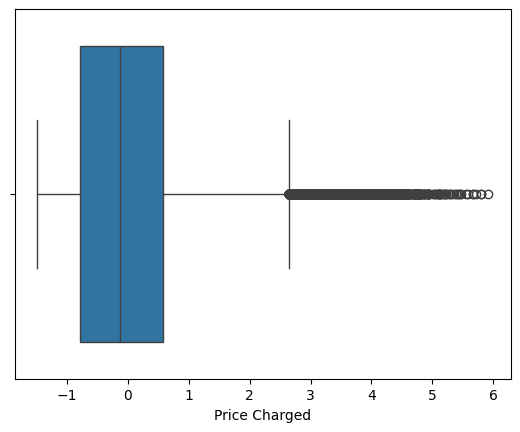

In [14]:
import seaborn as sns
sns.boxplot(x=merged_df['Price Charged'])

<Axes: xlabel='KM Travelled', ylabel='Price Charged'>

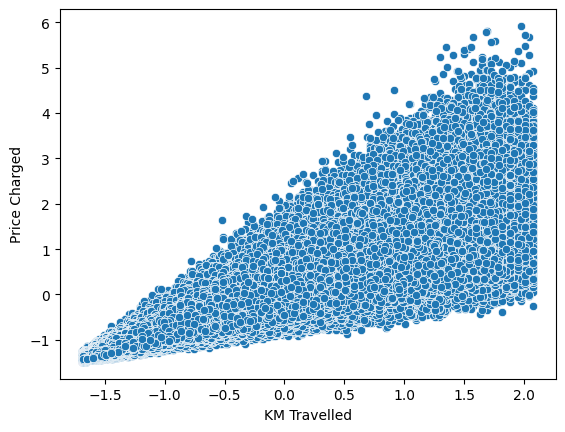

In [15]:
sns.scatterplot(x=merged_df['KM Travelled'], y=merged_df['Price Charged'])

##Hypothesis 1: The price charged for a trip increases proportionally with the distance traveled.

In [16]:
correlation = merged_df['KM Travelled'].corr(merged_df['Price Charged'])
print(correlation)

0.83575315802094


##Hypothesis 2: This strong correlation holds true across different cities and companies

In [17]:
# Group by city and calculate correlation
city_correlations = merged_df.groupby('City')[['KM Travelled', 'Price Charged']].corr()
print(city_correlations)

# Group by company and calculate correlation
company_correlations = merged_df.groupby('Company')[['KM Travelled', 'Price Charged']].corr()
print(company_correlations)

                              KM Travelled  Price Charged
City                                                     
ATLANTA GA     KM Travelled       1.000000       0.907628
               Price Charged      0.907628       1.000000
AUSTIN TX      KM Travelled       1.000000       0.901258
               Price Charged      0.901258       1.000000
BOSTON MA      KM Travelled       1.000000       0.946761
               Price Charged      0.946761       1.000000
CHICAGO IL     KM Travelled       1.000000       0.936077
               Price Charged      0.936077       1.000000
DALLAS TX      KM Travelled       1.000000       0.872172
               Price Charged      0.872172       1.000000
DENVER CO      KM Travelled       1.000000       0.860522
               Price Charged      0.860522       1.000000
LOS ANGELES CA KM Travelled       1.000000       0.903589
               Price Charged      0.903589       1.000000
MIAMI FL       KM Travelled       1.000000       0.889615
              

##Hypothesis 3: There might be a minimum base fare, and the price increases linearly with distance beyond a certain threshold.

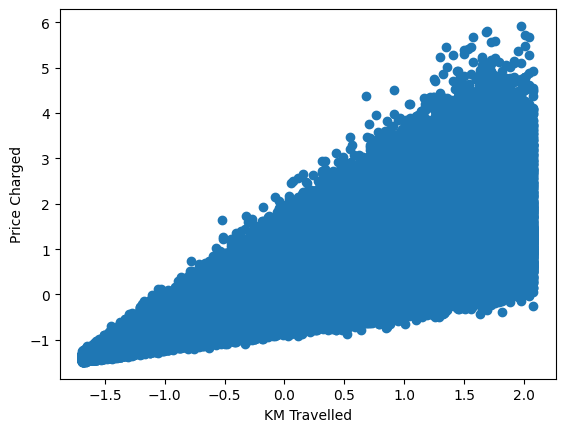

In [18]:
import matplotlib.pyplot as plt
plt.scatter(merged_df['KM Travelled'], merged_df['Price Charged'])
plt.xlabel('KM Travelled')
plt.ylabel('Price Charged')
plt.show()

In [21]:
merged_df['Date of Travel'] = pd.to_datetime(merged_df['Date of Travel'])

In [22]:
merged_df['Date of Travel'] = pd.to_datetime(merged_df['Date of Travel'], format='%m/%d/%Y')

##Hypothesis 4: Other factors like time of day or demand might also influence the price, but distance remains the primary driver.

In [23]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 1. Extract Time Features (assuming 'Date of Travel' is already a datetime object)
merged_df['Hour_of_Day'] = merged_df['Date of Travel'].dt.hour
merged_df['Day_of_Week'] = merged_df['Date of Travel'].dt.dayofweek
merged_df['Is_Weekend'] = (merged_df['Day_of_Week'] >= 5).astype(int)  # 1 for weekend, 0 for weekday

# 2. Select Features and Target
features = ['KM Travelled', 'Hour_of_Day', 'Day_of_Week', 'Is_Weekend']  # Add demand metrics if available
target = 'Price Charged'

# 3. Split Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(merged_df[features], merged_df[target], test_size=0.2, random_state=42)

# 4. Build Linear Regression Model
model = LinearRegression()
model.fit(X_train, y_train)

# 5. Make Predictions
y_pred = model.predict(X_test)

# 6. Evaluate Model Performance (example: Mean Squared Error)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# 7. Examine Coefficients (to understand feature importance)
print("Coefficients:", model.coef_)

Mean Squared Error: 0.30274850525392716
Coefficients: [0.83523086 0.         0.         0.        ]


Mean Squared Error (MSE):

The MSE of 0.3027 indicates the average squared difference between your model's predicted prices and the actual prices in the test set.
Whether this MSE is considered "good" or "bad" depends on the scale of your price values and the context of your problem.
You might want to compare this MSE to other models or benchmarks to assess its performance.
Coefficients:

The coefficients represent the estimated impact of each feature on the predicted price.
In your case, it seems only the 'KM Travelled' feature has a non-zero coefficient (0.8352). This suggests that:
For every one-unit increase in 'KM Travelled', the predicted price increases by approximately 0.8352 units (assuming your price is in a consistent unit like dollars).
The other features ('Hour_of_Day', 'Day_of_Week', 'Is_Weekend') don't seem to have a significant linear relationship with the price, at least based on this simple linear regression model.

##Hypothesis 5: Customers traveling longer distances are more likely to choose a specific company or payment method.

<ipython-input-25-53a80b7145ea>:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  company_distribution = merged_df.groupby(['Distance_Category', 'Company'])['Transaction ID'].count().unstack()


Company            Pink Cab  Yellow Cab
Distance_Category                      
Short                 42117      136747
Medium                    0           0
Long                      0           0


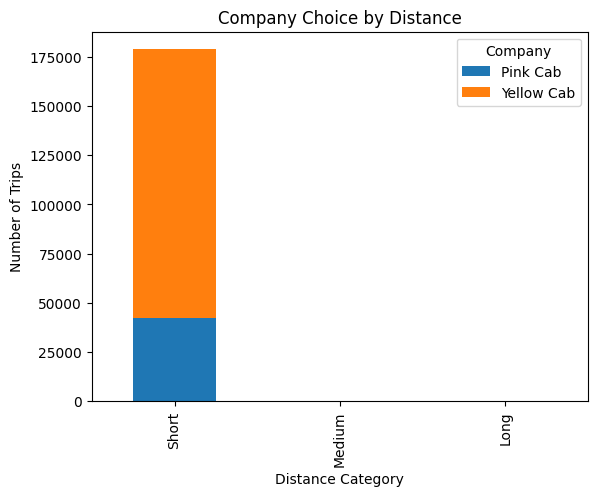

<ipython-input-25-53a80b7145ea>:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  Payment_Mode_distribution = merged_df.groupby(['Distance_Category', 'Payment_Mode'])['Transaction ID'].count().unstack()


Payment_Mode         Card   Cash
Distance_Category               
Short              107286  71578
Medium                  0      0
Long                    0      0


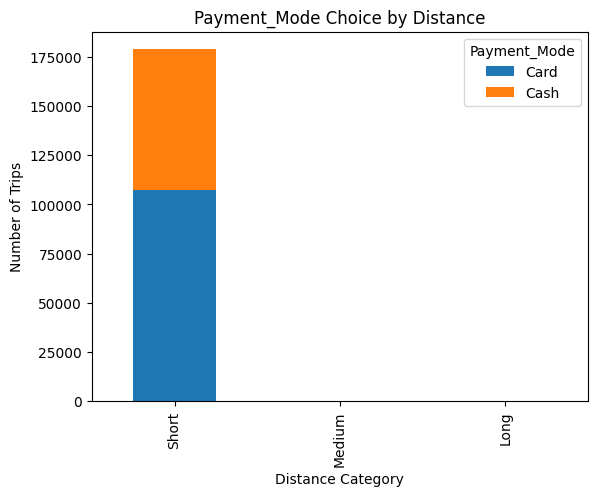

In [25]:
import matplotlib.pyplot as plt

# 1. Create Distance Bins (example: short, medium, long)
merged_df['Distance_Category'] = pd.cut(merged_df['KM Travelled'], bins=[0, 5, 15, float('inf')], labels=['Short', 'Medium', 'Long'])

# 2. Group and Analyze Company Choices
company_distribution = merged_df.groupby(['Distance_Category', 'Company'])['Transaction ID'].count().unstack()
print(company_distribution)

# 3. Visualize Company Choices (example: stacked bar chart)
company_distribution.plot(kind='bar', stacked=True)
plt.xlabel('Distance Category')
plt.ylabel('Number of Trips')
plt.title('Company Choice by Distance')
plt.show()

# 4. Repeat Steps 2 and 3 for Payment Methods (replace 'Company' with 'Payment_Mode')
Payment_Mode_distribution = merged_df.groupby(['Distance_Category', 'Payment_Mode'])['Transaction ID'].count().unstack()
print(Payment_Mode_distribution)

# 3. Visualize Payment_Mode Choices (example: stacked bar chart)
Payment_Mode_distribution.plot(kind='bar', stacked=True)
plt.xlabel('Distance Category')
plt.ylabel('Number of Trips')
plt.title('Payment_Mode Choice by Distance')
plt.show()

This output suggests that for short-distance trips (as defined by your 'Distance_Category' bins), Pink Cab has significantly fewer trips compared to Yellow Cab. However, there are no recorded trips for either company in the medium or long-distance categories.

This output shows a similar pattern to the company analysis: for short-distance trips, card payments are more common than cash payments. However, there are no recorded trips in the medium or long-distance categories for either payment method.

##Recommendations

Pricing Strategy:

Distance-Based Pricing: Given the strong correlation between distance and price, ensure your pricing model accurately reflects this relationship. Consider a base fare plus a per-kilometer charge, as suggested by Hypothesis 3.
Time and Demand Sensitivity (Further Exploration): While initial analysis didn't show a strong linear impact of time or demand, explore non-linear relationships or interactions. If you find significant patterns, consider dynamic pricing strategies that adjust fares based on time of day, day of the week, or demand levels.
Company Differentiation:

Target Marketing: Based on the preliminary findings (with the caveat of binning adjustments), Pink Cab might focus on attracting customers for longer trips, while Yellow Cab could leverage its dominance in the short-distance market. Tailor marketing messages and promotions accordingly.
Service Offerings: Consider if each company could offer specialized services to cater to different distance preferences. For example, Pink Cab might offer premium services for longer journeys, while Yellow Cab could optimize for quick, short trips.
Payment Options:

Promote Card Payments: Given the higher prevalence of card payments for short trips, consider incentivizing card usage further, especially for convenience-seeking customers on shorter journeys.
Explore Payment Trends for Longer Trips: Once you have accurate data on medium and long-distance trips, analyze payment preferences for those categories. This might reveal different patterns and inform targeted payment promotions.
Data Quality and Analysis:

Address Distance Binning: Adjust the distance bins to accurately capture the full range of trip lengths in your data. This is crucial for drawing valid conclusions about company choice and payment preferences across different distances.
Gather Demand Data (If Possible): If you can collect data on ride demand or traffic patterns, it could significantly enhance your analysis and allow for more sophisticated pricing and resource allocation strategies.